In [1]:
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional
from tensorflow.keras import activations
import matplotlib.pyplot as plt

import numpy as np
import time

from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM, Flatten


In [6]:
df = pd.read_csv("Data/allFall_delhi.csv")
df['From Date'] = df['Datetime']

df = df[['From Date','O3','Temperature','SO2','PM10','NO2','CO']] # new features : 6
df = df.replace(to_replace='None', value=np.nan)
df = df.dropna(axis = 0, how = 'all')
df['SO2'].fillna(df['SO2'].median(), inplace=True)

df = df.set_index('From Date')
df = df.iloc[::3, :]
df.to_csv('data1.csv')
print(df.columns)

print(" \nCount total NaN at each column in a DataFrame : \n\n", df.isnull().sum())

Index(['O3', 'Temperature', 'SO2', 'PM10', 'NO2', 'CO'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 O3             0
Temperature    0
SO2            0
PM10           0
NO2            0
CO             0
dtype: int64


In [7]:
# print(df)
dataset = read_csv('data1.csv', index_col=0)
dataset.columns = ['O3','Temperature','SO2','PM10','NO2','CO']
dataset.index.name = 'From Date'
# dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution1.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                        O3  Temperature    SO2    PM10     NO2    CO
From Date                                                           
2015-10-04 0:00:00   53.33         80.6  16.59  510.44  121.57  4.16
2015-10-04 3:00:00   59.55         78.8  25.13  439.12   81.16  2.87
2015-10-04 6:00:00   33.09         71.6   6.01  349.50   54.30  1.95
2015-10-04 9:00:00   25.57         84.2   9.91  308.01   70.53  1.62
2015-10-04 12:00:00  74.46         95.0  19.38  249.95   31.37  1.06
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


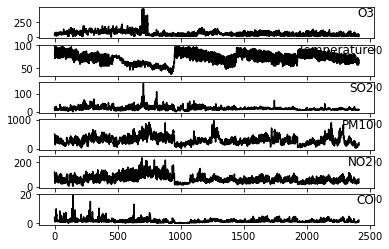

In [8]:
import pandas as pd
from matplotlib import pyplot

dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 4, 5]

i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group],'k')
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [24]:
from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML

# load dataset
dataset = read_csv('pollution1.csv', header=0, index_col=0)
# ensure all data is float
values = dataset.values
values = values.astype('float32')
scaler = RobustScaler()
scaled = scaler.fit_transform(values)
n_hours = 8
n_features = 6 # changed features from 5 to six
reframed = series_to_supervised(scaled, n_hours, 8)
print(reframed.shape)

(2401, 96)


TRIAL  0
(2401, 96)
(2000, 48) 2000 (2000,)
(2000, 8, 6) (2000,) (401, 8, 6) (401,)
Epoch 1/25
28/28 - 325s - loss: 0.5945 - val_loss: 0.2221
Epoch 2/25
28/28 - 10s - loss: 0.6011 - val_loss: 0.1733
Epoch 3/25
28/28 - 8s - loss: 0.4655 - val_loss: 0.1340
Epoch 4/25
28/28 - 9s - loss: 0.4490 - val_loss: 0.1179
Epoch 5/25
28/28 - 8s - loss: 0.4320 - val_loss: 0.0975
Epoch 6/25
28/28 - 8s - loss: 0.4306 - val_loss: 0.1090
Epoch 7/25
28/28 - 8s - loss: 0.4268 - val_loss: 0.0933
Epoch 8/25
28/28 - 8s - loss: 0.4284 - val_loss: 0.0911
Epoch 9/25
28/28 - 8s - loss: 0.4168 - val_loss: 0.0769
Epoch 10/25
28/28 - 8s - loss: 0.4127 - val_loss: 0.0816
Epoch 11/25
28/28 - 8s - loss: 0.3926 - val_loss: 0.0695
Epoch 12/25
28/28 - 9s - loss: 0.3961 - val_loss: 0.0719
Epoch 13/25
28/28 - 8s - loss: 0.3851 - val_loss: 0.0708
Epoch 14/25
28/28 - 8s - loss: 0.3897 - val_loss: 0.0664
Epoch 15/25
28/28 - 9s - loss: 0.3698 - val_loss: 0.0635
Epoch 16/25
28/28 - 8s - loss: 0.3849 - val_loss: 0.0651
Epoch 17/2

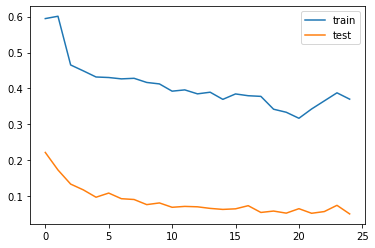

done | time taken: 519.230433 seconds
Test RMSE: 12.391
9.35717
0.7464434100175017


In [35]:
rmses = []
maes = []
rsquared = []
times = []

from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=20, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML


for z in range(1):
    t0 = time.time()
    print('TRIAL ', z)
    # load dataset
    dataset = read_csv('pollution1.csv', header=0, index_col=0)
    # dataset = dataset[2000:6000]
    # ensure all data is float
    values = dataset.values
    values = values.astype('float32')
    scaler = RobustScaler()
    scaled = scaler.fit_transform(values)
    n_hours = 8
    n_features = 6 # changed features from 5 to six
    reframed = series_to_supervised(scaled, n_hours, 8)
    print(reframed.shape)


    # split into train and test sets
    values = reframed.values
    n_train_hours = 2000
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    n_obs = n_hours * n_features
    train_X = train[:, :n_obs]
    train_y = train[:, -n_features]
    test_X = test[:, :n_obs]
    test_y = test[:, -n_features]
    
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    n_out = 1
    #######


    # Building the model
    model = Sequential()
    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(256,return_sequences=True, dropout=0.2, input_shape=(n_hours,n_features)))) # change number of neurons to 256, 128
    model.add(Bidirectional(LSTM(128, dropout=0.2)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')


    ########## ^ normal
    # model = Sequential()
    # model.add(Bidirectional(LSTM(64, activation='selu', return_sequences=True), input_shape=(n_hours, n_features)))
    # model.add(Bidirectional(LSTM(64, activation='selu', return_sequences=True)))
    # model.add(Bidirectional(LSTM(50, activation='selu')))
    # model.add(Dense(1))
    # model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    #####

    history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False) # try combo


    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat) #################
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    from sklearn.metrics import mean_absolute_error, r2_score

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -5:]), axis=1) # changed from -7 to -11 to -5 # because it is n_features-1. also had really good results for -11?
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = (mean_absolute_error(inv_y, inv_yhat))
    r2 = (r2_score(inv_y, inv_yhat))



    t1 = time.time()


    total = t1-t0

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    print("done | time taken: %f seconds" %total)
    print('Test RMSE: %.3f' % rmse)
    print(mae)
    print(r2)
    
    maes.append(mae)
    rmses.append(rmse)
    rsquared.append(r2)
    times.append(total)
#print(mae)

In [34]:
mymae = [round(x, 2) for x in maes]
myrmse = [round(x, 2) for x in rmses]
myrsquared = [round(x, 2) for x in rsquared]
mytime = [round(x, 2) for x in times]

print(mymae)
print(myrmse)
print(myrsquared)
print(mytime)

[10.02]
[13.32]
[0.59]
[164.61]


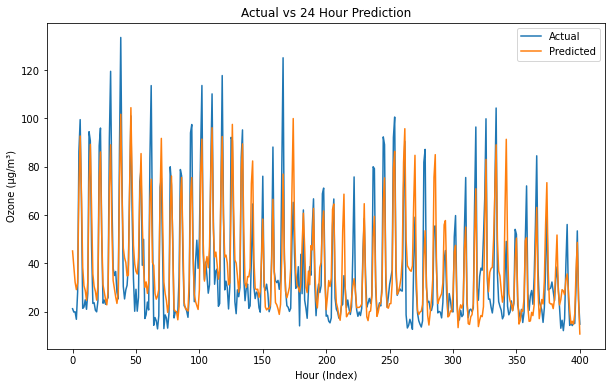

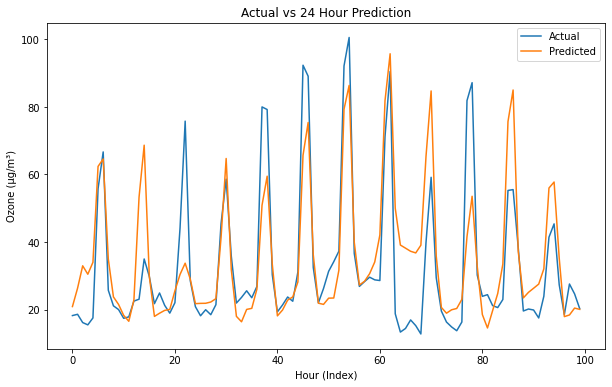

In [14]:
### plots

# entire thing

actual = inv_y
pred2 = inv_yhat
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

# sample

actual = inv_y[200:300]
pred2 = inv_yhat[200:300]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

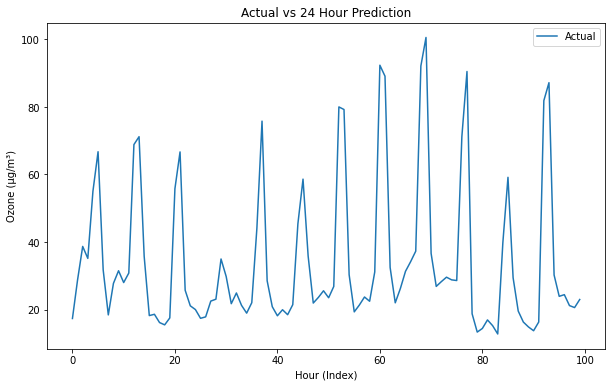

In [21]:
# sample = (dataset['O3'][2200:2300])


# plt.figure(figsize=(10,6))
# plt.plot( list(sample))
# plt.title("Actual vs 24 Hour Prediction")
# plt.ylabel('Ozone (µg/m³)')
# plt.xlabel("Hour (Index)")
# plt.legend(('Actual','Predicted'))
# plt.show()

In [ ]:
### only predicting

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat) #################
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
from sklearn.metrics import mean_absolute_error, r2_score

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1) # changed from -7 to -11 to -5 # because it is n_features-1. also had really good results for -11?
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = (mean_absolute_error(inv_y, inv_yhat))
r2 = (r2_score(inv_y, inv_yhat))



t1 = time.time()


total = t1-t0

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

print("done | time taken: %f seconds" %total)
print('Test RMSE: %.3f' % rmse)
print(mae)
print(r2)